In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from theano import tensor as ts
import pymc3 as pm

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (8,6)

In [2]:
#from blaze import Data
#from odo import odo

#t = Data("sqlite:///data.sqlite3::train")
#t = t.sample(n=20000)
#odo(t, "downloads/samp-20k.csv")

In [3]:
usecols = ["week_num","agency_id","product_id","adjusted_demand"]
samps = pd.read_csv("downloads/samp-20k.csv", usecols=usecols)
samps.head()

,week_num,agency_id,product_id,adjusted_demand
0,4,1170,325,12
1,9,2036,3631,8
2,5,2230,4085,1
3,8,4061,34891,54
4,6,1242,36008,6


In [4]:
n_weeks = len(samps.week_num.unique())
n_products = len(samps.product_id.unique())
n_agencies = len(samps.agency_id.unique())

In [5]:
print("Number of weeks: {}\n Number of products: {}\n Number of agencies {}".format(n_weeks,n_products,n_agencies))

Number of weeks: 7
 Number of products: 660
 Number of agencies 480


In [6]:
week_lb = LabelEncoder()
week_code = week_lb.fit_transform(samps.week_num)

agency_lb = LabelEncoder()
agency_code = agency_lb.fit_transform(samps.agency_id)

product_lb = LabelEncoder()
product_code = product_lb.fit_transform(samps.product_id)

In [7]:
week_code

array([1, 6, 2, ..., 1, 1, 0])

In [8]:
product_code

array([ 12,  78,  83, ..., 465, 496,  46])

In [9]:
agency_code

array([ 36, 329, 378, ..., 129, 317, 317])

In [10]:
pois_model = pm.Model()

with pois_model:
    intercept = pm.Normal("intercept", mu=1, sd=10)
    week_rate = pm.Normal("week_rate", 100, shape=n_weeks)
    agency_rate = pm.Normal("agency_rate", 100, shape=n_agencies)
    product_rate = pm.Normal("product_rate", 100, shape=n_products)
    demand_rate = intercept + week_rate[week_code] + product_rate[product_code] + agency_rate[agency_code]
    adjusted_demand = pm.Poisson("adjusted_demand", mu=demand_rate, observed=samps.adjusted_demand)

In [11]:
pois_model.vars

[intercept, week_rate, agency_rate, product_rate]

In [12]:
with pois_model:
    means, stds, elbos = pm.advi(n=2000)

Iteration 0 [0%]: ELBO = -5498849.56
Iteration 200 [10%]: ELBO = -5478364.04
Iteration 400 [20%]: ELBO = -5478047.71
Iteration 600 [30%]: ELBO = -5454957.58
Iteration 800 [40%]: ELBO = -5492173.81
Iteration 1000 [50%]: ELBO = -5471725.76
Iteration 1200 [60%]: ELBO = -5443140.92
Iteration 1400 [70%]: ELBO = -5453081.81
Iteration 1600 [80%]: ELBO = -5455334.86
Iteration 1800 [90%]: ELBO = -5445645.08
Finished [100%]: ELBO = -5435708.6


In [13]:
with pois_model:
    step = pm.NUTS(scaling=means)
    pois_trace = pm.sample(500, step=step)

WARNING (theano.tensor.blas): We did not found a dynamic library into the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


 [-----------------100%-----------------] 501 of 500 complete in 401.3 sec

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f296a29f7f0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f296997ba90>]], dtype=object)

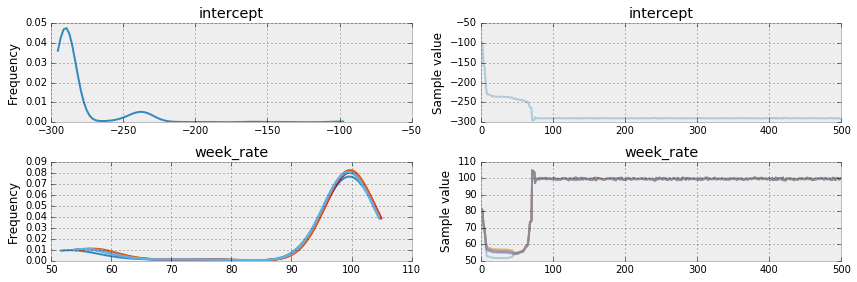

In [14]:
pm.traceplot(pois_trace, varnames=["intercept", "week_rate"])

In [17]:
pois_model.observed_RVs

[adjusted_demand]

In [24]:
ppc = pm.sample_ppc(pois_trace, model=pois_model, vars=[adjusted_demand])["adjusted_demand"]

In [26]:
n_samp = ppc.shape[0]

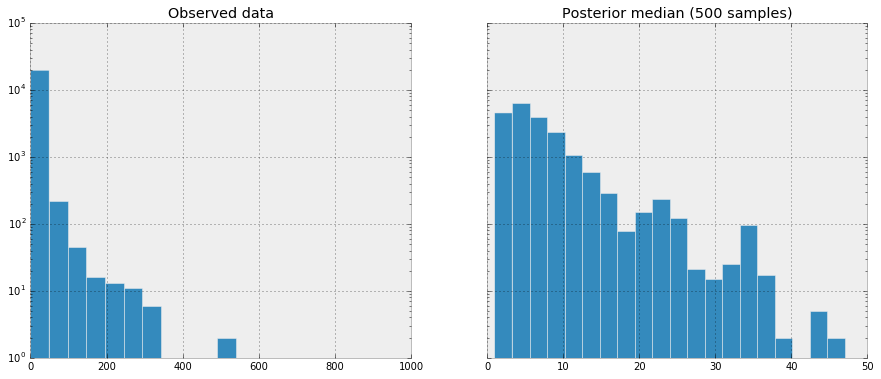

In [33]:
fig,axs = plt.subplots(nrows=1, ncols=2, figsize=(15,6), sharey=True)

axs[0].hist(samps.adjusted_demand, bins=20, log=True)
axs[0].set_title("Observed data")

axs[1].hist(np.median(ppc, axis=0), bins=20)
axs[1].set_title("Posterior median (%d samples)" % n_samp)